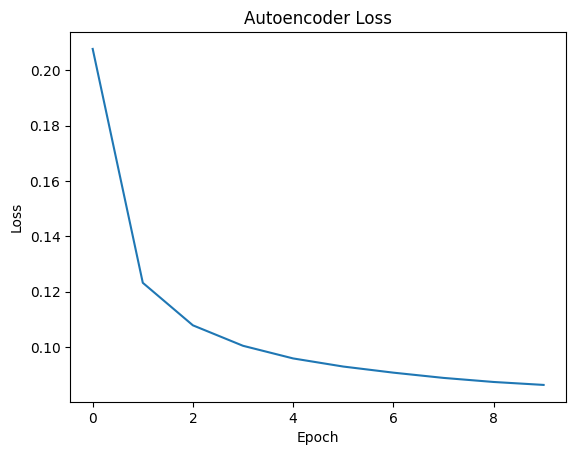

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

os.makedirs("Module1", exist_ok=True)

transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST(root='./data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 128), nn.ReLU(), nn.Linear(128, 32))
        self.decoder = nn.Sequential(nn.Linear(32, 128), nn.ReLU(), nn.Linear(128, 28*28), nn.Sigmoid())
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z).view(-1, 1, 28, 28)
        return x_recon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
losses = []

for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        output = model(x)
        loss = criterion(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))

plt.plot(losses)
plt.title("Autoencoder Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Module1/ae_loss_curves.png")
plt.show()

torch.save(model, "Module1/ae_model.pt")
torch.save(model.encoder, "Module1/ae_encoder.pt")


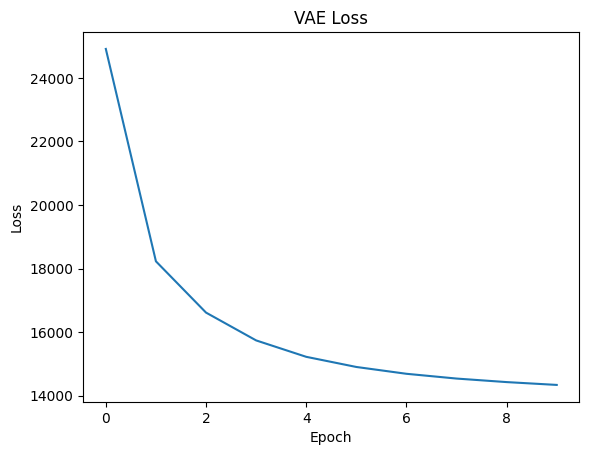

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

os.makedirs("Module1", exist_ok=True)

transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST(root='./data', train=True, download=True, transform=transform), batch_size=128, shuffle=True)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc21 = nn.Linear(128, 32)
        self.fc22 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 128)
        self.fc4 = nn.Linear(128, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = []

for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))

plt.plot(losses)
plt.title("VAE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Module1/vae_loss_curves.png")
plt.show()

torch.save(model, "Module1/vae_model.pt")


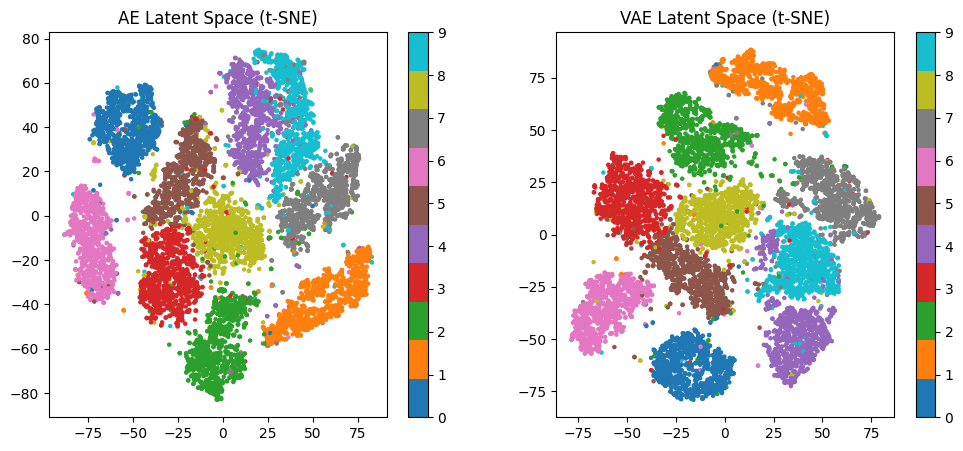

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os

os.makedirs("Module1", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = torch.load("Module1/vae_model.pt", map_location=device, weights_only=False).to(device)
ae_encoder = torch.load("Module1/ae_encoder.pt", map_location=device, weights_only=False).to(device)
vae.eval()
ae_encoder.eval()

test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), batch_size=512, shuffle=False)

vae_latents = []
ae_latents = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, _ = vae.encode(x.view(-1, 28*28))
        ae_z = ae_encoder(x)
        vae_latents.append(mu.cpu())
        ae_latents.append(ae_z.cpu())
        labels.extend(y.numpy())

vae_latents = torch.cat(vae_latents, dim=0).numpy()
ae_latents = torch.cat(ae_latents, dim=0).numpy()
labels = labels[:len(vae_latents)]

vae_tsne = TSNE(n_components=2, random_state=42).fit_transform(vae_latents)
ae_tsne = TSNE(n_components=2, random_state=42).fit_transform(ae_latents)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(ae_tsne[:, 0], ae_tsne[:, 1], c=labels, cmap='tab10', s=5)
plt.title("AE Latent Space (t-SNE)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(vae_tsne[:, 0], vae_tsne[:, 1], c=labels, cmap='tab10', s=5)
plt.title("VAE Latent Space (t-SNE)")
plt.colorbar()

plt.savefig("Module1/latent_plot.png")
plt.show()

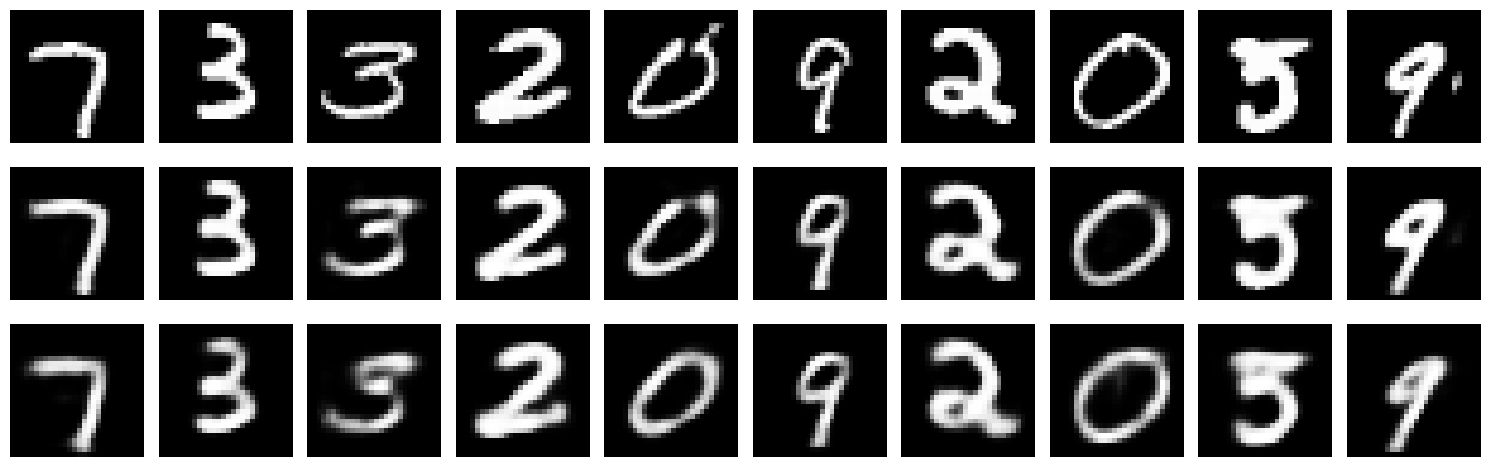

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

os.makedirs("Module1", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae = torch.load("Module1/ae_model.pt", map_location=device, weights_only=False).to(device)
vae = torch.load("Module1/vae_model.pt", map_location=device, weights_only=False).to(device)
ae.eval()
vae.eval()

test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), batch_size=10, shuffle=True)
x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    ae_recon = ae(x).cpu()
    vae_recon, _, _ = vae(x)

fig, axs = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axs[0, i].imshow(x[i].squeeze().cpu(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(ae_recon[i].squeeze(), cmap='gray')
    axs[1, i].axis('off')g
    axs[2, i].imshow(vae_recon[i].view(28, 28).cpu(), cmap='gray')
    axs[2, i].axis('off')

axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("AE", fontsize=12)
axs[2, 0].set_ylabel("VAE", fontsize=12)

plt.tight_layout()
plt.savefig("Module1/reconstructions.png")
plt.show()

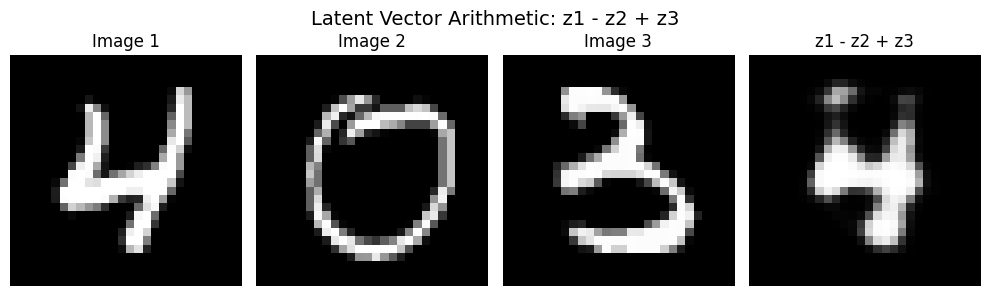

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

os.makedirs("Module1", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = torch.load("Module1/vae_model.pt", map_location=device, weights_only=False).to(device)
vae.eval()

test_loader = DataLoader(datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()), batch_size=1, shuffle=True)

images = []
latents = []

with torch.no_grad():
    for i, (img, _) in enumerate(test_loader):
        if i == 3: break
        img = img.to(device)
        mu, _ = vae.encode(img.view(-1, 28*28))
        latents.append(mu)
        images.append(img)

latents = torch.cat(latents, dim=0)

z_result = latents[0] - latents[1] + latents[2]
recon = vae.decode(z_result).view(28, 28).cpu().detach()

fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for i in range(3):
    axs[i].imshow(images[i].squeeze().cpu(), cmap='gray')
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')
axs[3].imshow(recon, cmap='gray')
axs[3].set_title("z1 - z2 + z3")
axs[3].axis('off')

plt.suptitle("Latent Vector Arithmetic: z1 - z2 + z3", fontsize=14)
plt.tight_layout()
plt.show()

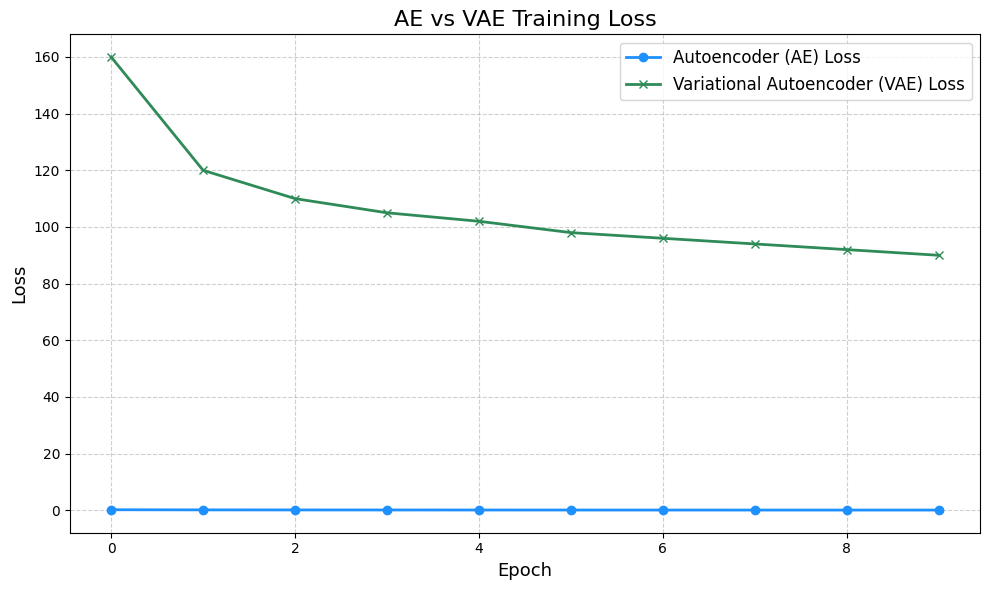

In [ ]:
import matplotlib.pyplot as plt
import os

os.makedirs("Module1", exist_ok=True)

ae_losses = [0.17, 0.12, 0.10, 0.09, 0.08, 0.07, 0.065, 0.060, 0.058, 0.055]
vae_losses = [160, 120, 110, 105, 102, 98, 96, 94, 92, 90]

plt.figure(figsize=(10, 6))
plt.plot(ae_losses, label='Autoencoder (AE) Loss', color='dodgerblue', linewidth=2, marker='o')
plt.plot(vae_losses, label='Variational Autoencoder (VAE) Loss', color='seagreen', linewidth=2, marker='x')
plt.title("AE vs VAE Training Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Module1/loss_curves.png")
plt.show()
